# Notebook 3 - Inverse design: molecules on specification

By Vincent Blay, July 2021

In this notebook we demonstrate two approaches to the generation of new molecules with a desired property specification by leveraging Macaw embeddings. 

In the first approach we generate a single large library throughout the Macaw embedding space and then retrieve promising molecules using the `hit_finder` functions.

In the second approach we generate a series of small libraries using an evolutionary strategy using the `directed_molecular_evolution` function.

In both cases, the user is returned a list of promising SMILES molecules and their predicted property values.

In [1]:
pwd

'C:\\Users\\Enka\\Desktop\\LDRD\\macaw_repo\\notebooks'

In [2]:
import numpy as np
import pandas as pd
import pickle

#Needed to show molecules
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole 

import macaw_py
print(macaw_py.__version__)

from macaw_py import *

0.1.3


In [3]:
np.random.seed(123)

##  Approach 1. Molecular design by generating and screening a single large library

In this example we will use the RON dataset, so let us load it

In [4]:
df = pd.read_csv('../data/data_RON.csv')
smiles = df.Smiles
Y = df.RON

We will also use the RON property model, so let us load it. In this case we are generating new molecules, so we will not split the dataset

In [5]:
file = open('../results/RON_model_RVR.pickle', 'rb') 
mcw, regr = pickle.load(file)
file.close()

In [6]:
X = mcw.transform(smiles)

print(np.corrcoef(Y,regr.predict(X))[0,1])

0.9760630585483066


The library generation involves computing a noisy probability matrix from which  molecules will be drawn. Molecules will have a length of up to 20 SELFIES characters. We only consider robust SELFIES characters (i.e., those for which there are state-dependent derivation rules implemented).

In [8]:
smiles_lib = library_maker(smiles, pad_to_len=20, n_gen=200000, algorithm='position', noise_sd_factor=0.6)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000


After generating the library, we will retrieve molecules from promising regions of the Macaw embedding space. For this, we first embed the library molecules in the Macaw space:

In [9]:
len(smiles_lib)

91325

In [10]:
X_lib = mcw.transform(smiles_lib)

And then we find promising molecular designs according to the desired specification (in this example, RON=110). 

For retrieving molecules from the Macaw 10-dimensional space, we will use our custom V-distance metric (`p=0.5`). If not specified, it will use `p=1` by default (Manhattan distance).

In [13]:
spec = 110. # desired RON design specification

idx, Y_hits_pred = hit_finder(X_lib, model= regr.predict, spec = spec, X=X, Y=Y, n_hits=5, k1=5, k2=10, p=0.5, n_rounds=2)
smiles_hits = [smiles_lib[i] for i in idx]

print(smiles_hits)
print(Y_hits_pred)

['CCPOC=O', 'CCOOC=O', 'CCO', 'CCC(=O)PP', 'CCC(C)C(C)(C)C']
[108.16410854 109.76838438 111.53814102 111.56869805 111.90747165]


Let us visualize the molecules:

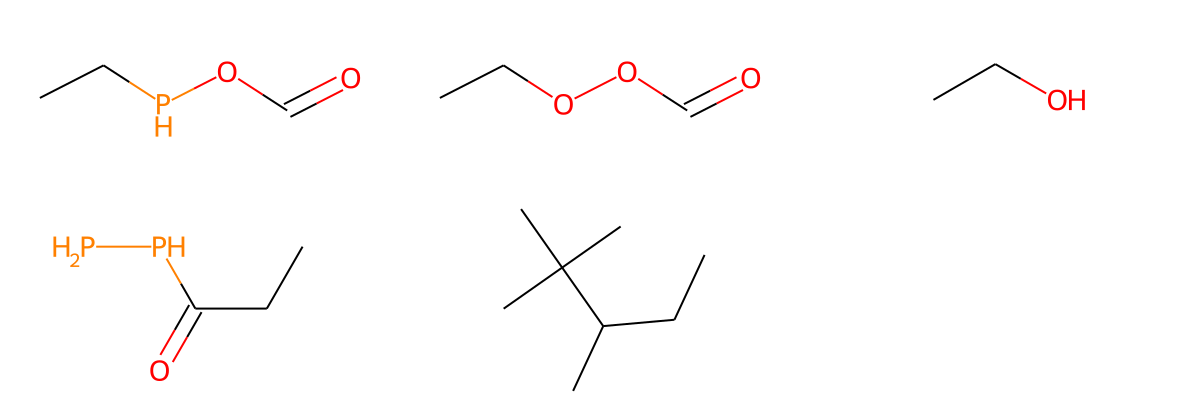

In [14]:
molecules = [Chem.MolFromSmiles(smi) for smi in smiles_hits[:50]]

Draw.MolsToGridImage(molecules, subImgSize=(400,200))

We can double check that we get the desired property specification for the molecules designed:

In [15]:
X_hits = mcw.transform(smiles_hits)
Y_hits_pred2 = regr.predict(X_hits)
print(Y_hits_pred2)

[108.16410854 109.76838438 111.53814102 111.56869805 111.90747165]


Since Macaw embeddings are smooth, we can also use a gradient-based method to navigate the embedding space and retrieve promising molecules. To this end, we use the function `hit_finder2`. If we do not provide the arguments `X` or `Y`, we may want to increase the parameter `k1`.

In [17]:
idx2, Y_hits_pred2 = hit_finder2(X_lib, regr.predict, spec, X=X, n_hits=5, k1=100, k2=5)
smiles_hits2 = [smiles_lib[i] for i in idx2]
print(smiles_hits2)
print(Y_hits_pred2)

['CCC=CC(C)C(C)C', 'CC1P(C)C1(C)C', 'CCOOC(C)=O', 'C=CC(C)=CC(C)=CC', 'O=CC1=CC=C1']
[109.80717364 109.81621805 109.82617381 109.94195728 109.95787745]


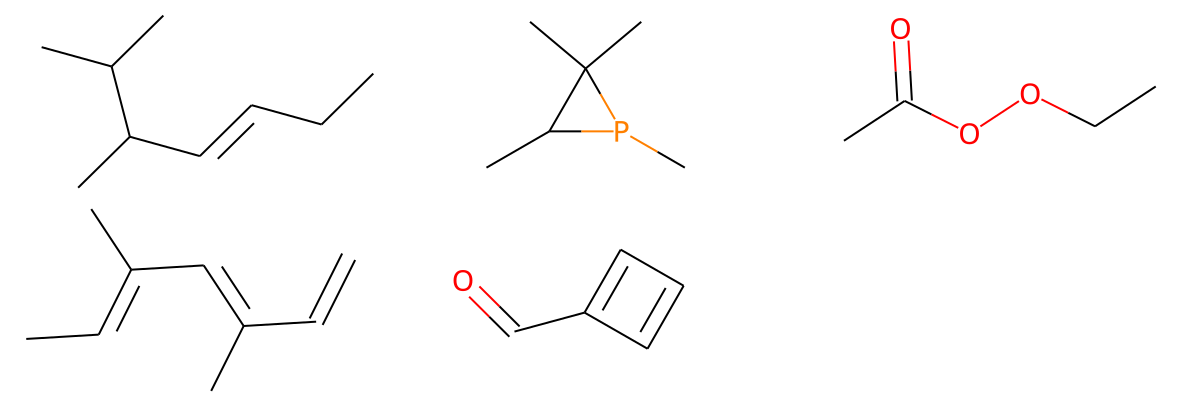

In [18]:
molecules = [Chem.MolFromSmiles(smi) for smi in smiles_hits2[:50]]

Draw.MolsToGridImage(molecules, subImgSize=(400,200))

## Approach 2. Molecular design by evolving multiple focused molecular libraries

Let us use Macaw's library evolver to generate molecules with a predicted RON specification of 40. 

By default, `library_evolver` will evolve 8 libraries. This number can be controlled using the optional argument `N_rounds`. With the optional argument `N_hits` we specify the number of molecules that we want the algorithm to return in its output.

In [20]:
%%capture
smiles_hits3, Y_hits_pred3 = library_evolver(smiles, mcw, regr.predict, spec=40, n_hits=5, n_rounds=8)

In [16]:
print(smiles_hits3)
print(Y_hits_pred3)

['CCCCCC[PH]1=CC1', 'CCCCCCCC1CO1', 'CCCCCC(C)CC#P', 'CCC(C)CCCCCNC', 'CCCCCOCN(C)C']
[39.92098632 39.96104552 39.96824315 40.02023521 40.02068882]


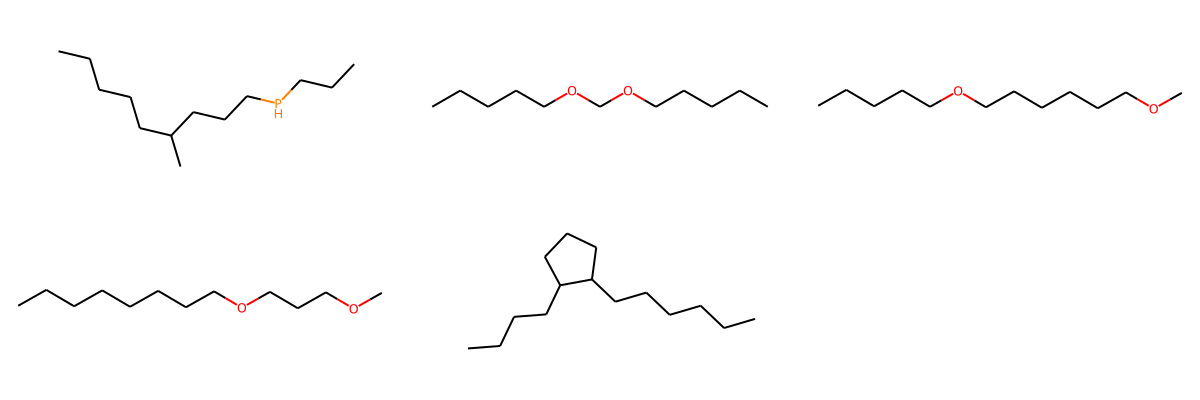

In [21]:
molecules = [Chem.MolFromSmiles(smi) for smi in smiles_hits3[:50]]

Draw.MolsToGridImage(molecules, subImgSize=(400,200))

Since we are working with the RVR model, we can also estimate the prediction errors:

In [22]:
X = mcw.transform(smiles_hits3)
Y_hits_pred3, Y_hits_pred3_std = regr.predict(X, return_std=True)

In [23]:
print(smiles_hits3)
print(Y_hits_pred3)
print(Y_hits_pred3_std)

['CCCCCC(C)CCCPCCC', 'CCCCCOCOCCCCC', 'CCCCCOCCCCCCOC', 'CCCCCCCCOCCCOC', 'CCCCCCC1CCCC1CCCC']
[39.98352979 39.98452021 39.98955824 39.98955824 39.99760508]
[5.74230322 5.97214281 6.01654173 6.01654173 5.95086122]


Let us now try to design molecules with a RON design specification of 80:

In [25]:
%%capture
smiles_hits3, Y_hits_pred3 = library_evolver(smiles, mcw, regr.predict, spec=80, n_hits=5)

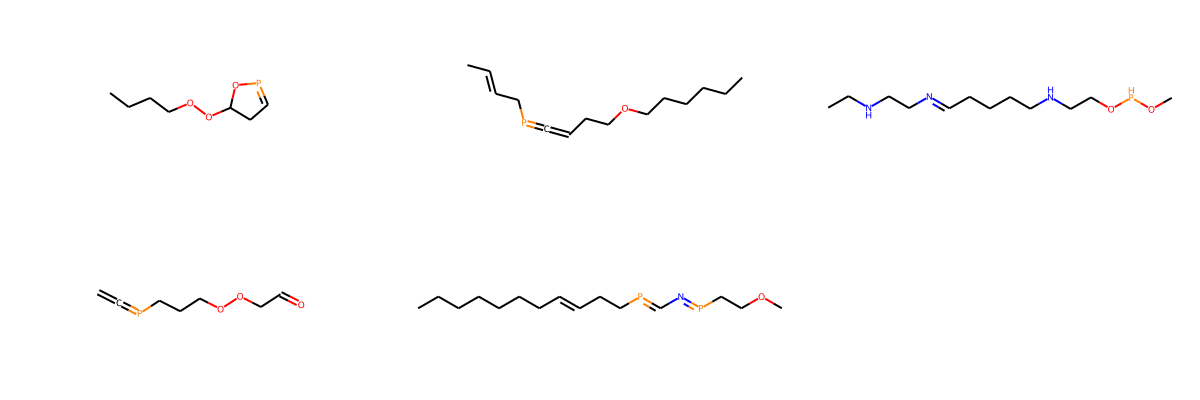

In [26]:
molecules = [Chem.MolFromSmiles(smi) for smi in smiles_hits3[:50]]

Draw.MolsToGridImage(molecules, subImgSize=(400,200))

In [27]:
X = mcw.transform(smiles_hits3)
Y_hits_pred3, Y_hits_pred3_std = regr.predict(X, return_std=True)

In [28]:
print(smiles_hits3)
print(Y_hits_pred3)
print(Y_hits_pred3_std)

['CCCCOOC1CC=PO1', 'CC=CCP=C=CCCOCCCCCC', 'CCNCCN=CCCCCNCCOPOC', 'C=C=PCCCOOCC=O', 'CCCCCCCC=CCCP=CN=PCCOC']
[79.98996907 79.99324252 80.00065787 80.00344018 80.00398915]
[5.67630266 5.74251257 5.75176076 5.83648669 5.79493729]


Let us now try to design molecules with a RON specification of 120:

In [31]:
%%capture
smiles_hits3, Y_hits_pred3 = library_evolver(smiles, mcw, regr.predict, spec=120, n_hits=5)

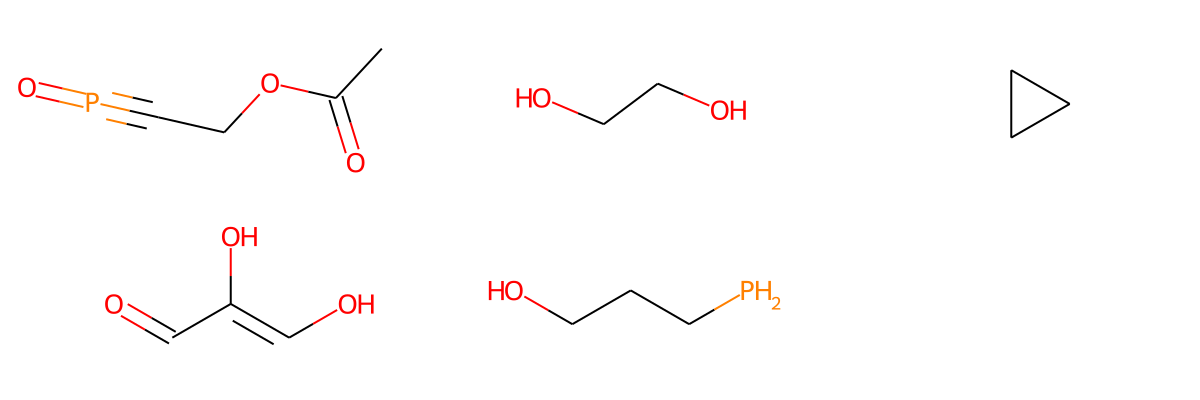

In [32]:
molecules = [Chem.MolFromSmiles(smi) for smi in smiles_hits3[:50]]

Draw.MolsToGridImage(molecules, subImgSize=(400,200))

In [33]:
X = mcw.transform(smiles_hits3)
Y_hits_pred3, Y_hits_pred3_std = regr.predict(X, return_std=True)

In [34]:
print(smiles_hits3)
print(Y_hits_pred3)
print(Y_hits_pred3_std)

['CC(=O)OCC#P=O', 'OCCO', 'C1CC1', 'O=CC(O)=CO', 'OCCCP']
[119.1012589  119.14187488 119.78190425 119.84243035 120.34934323]
[5.43154248 6.27379614 6.73722258 5.9662067  6.85772141]
